In [93]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from scipy import stats

# Загрузка данных

In [28]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [29]:
data.shape

(284, 1)

# График средней заработной платы

<AxesSubplot:xlabel='month'>

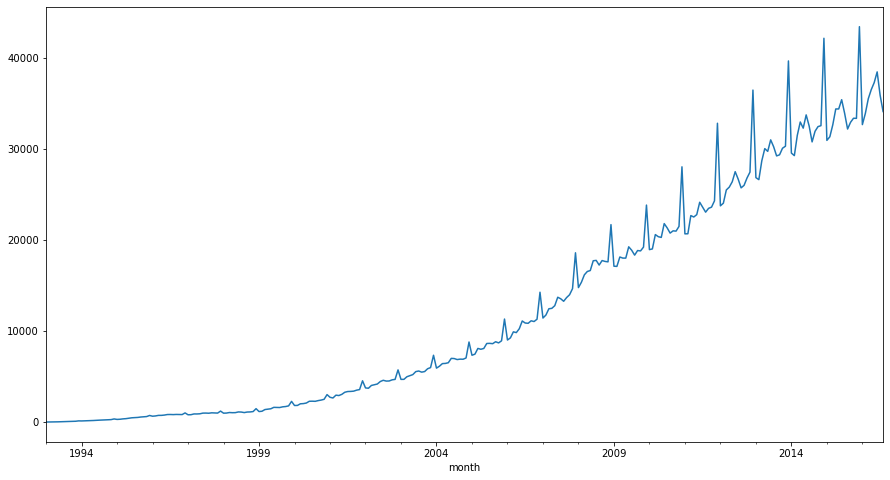

In [30]:
plt.figure(figsize=(15, 8))
data.WAG_C_M.plot()

# Преобразование данных

In [27]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


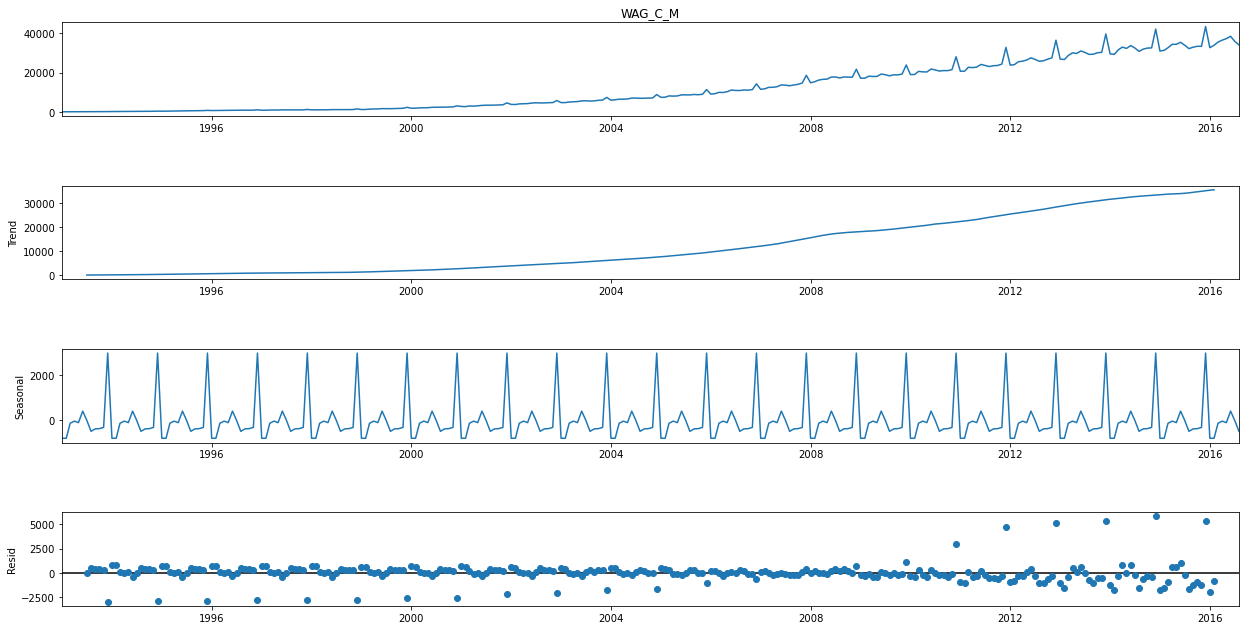

In [38]:
fig = sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
fig.set_size_inches((20, 10))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Ряд не является стационарным, присутствует тренд и структура в остатках

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [ ]:
data.WAG_C_M

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


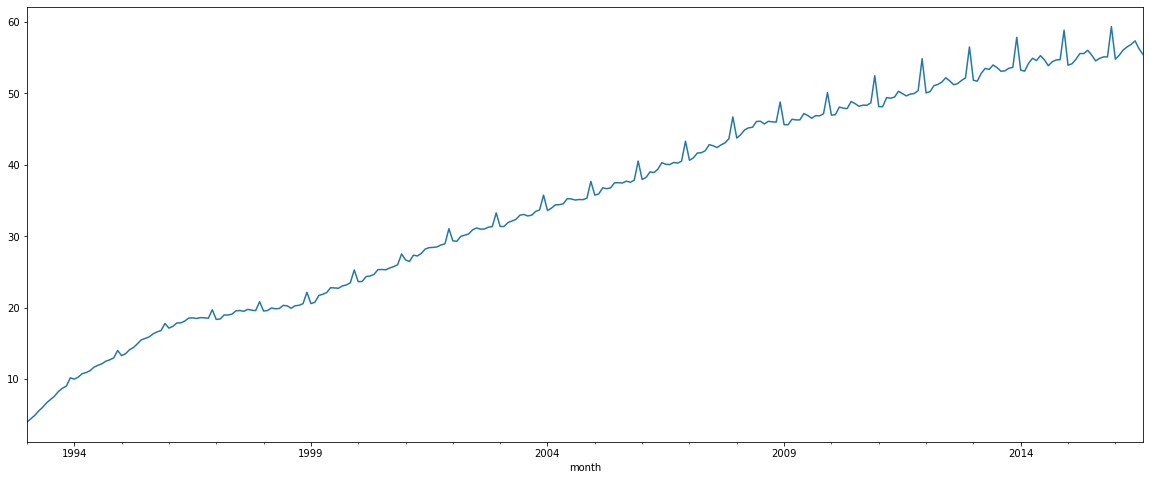

In [41]:
data['WAG_C_M_BOX'], lmbda = stats.boxcox(data.WAG_C_M)

plt.figure(figsize=(20, 8))
data.WAG_C_M_BOX.plot()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_BOX)[1])

Ряд всё ещё не является стационарным

Продифференцируем ряд:

Критерий Дики-Фуллера: p=0.014697


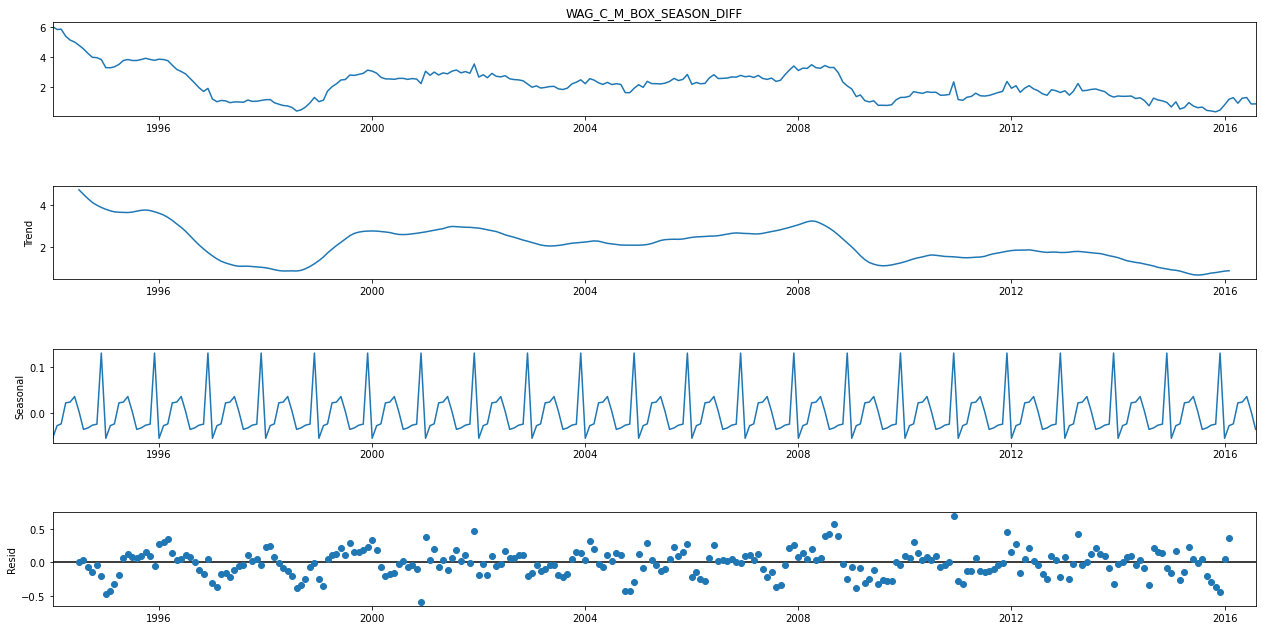

In [52]:
data['WAG_C_M_BOX_SEASON_DIFF'] = np.nan
data['WAG_C_M_BOX_SEASON_DIFF'] = data.WAG_C_M_BOX - data.WAG_C_M_BOX.shift(12)

fig = sm.tsa.seasonal_decompose(data.WAG_C_M_BOX_SEASON_DIFF[12:]).plot()
fig.set_size_inches((20, 10))

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_BOX_SEASON_DIFF[12:])[1])

Гипотеза нестационарности всё ещё не может быть отвергнута

Критерий Дики-Фуллера: p=0.000000


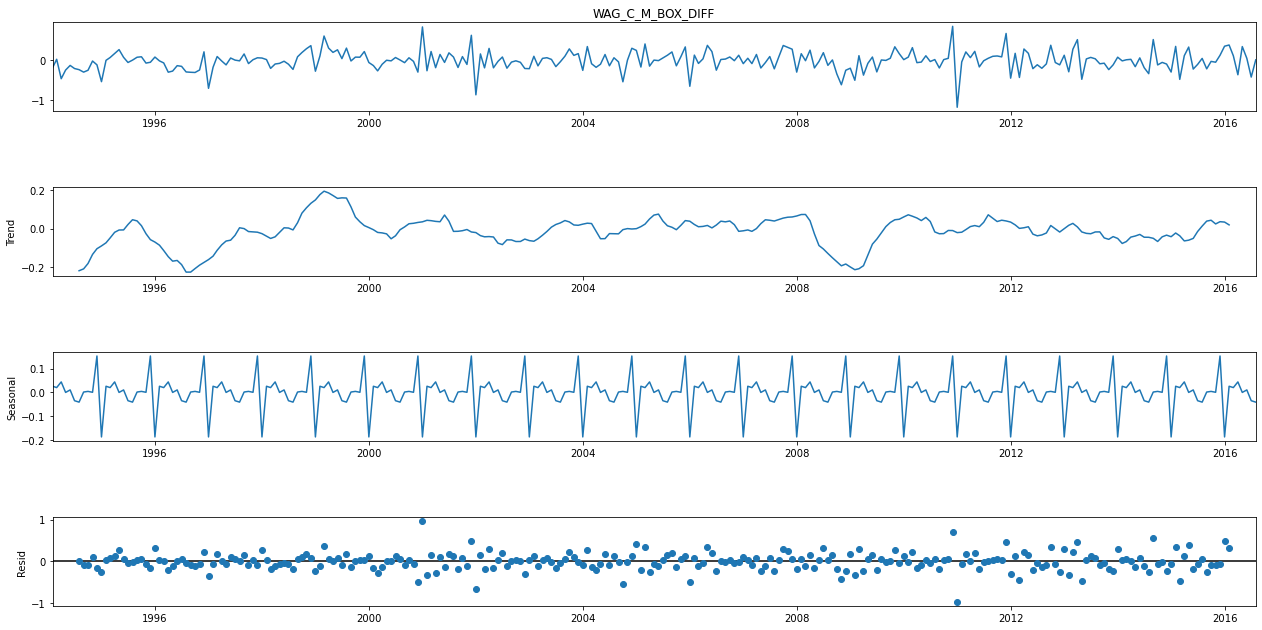

In [54]:
data['WAG_C_M_BOX_DIFF'] = np.nan
data['WAG_C_M_BOX_DIFF'] = data.WAG_C_M_BOX_SEASON_DIFF - data.WAG_C_M_BOX_SEASON_DIFF.shift(1)

fig = sm.tsa.seasonal_decompose(data.WAG_C_M_BOX_DIFF[13:]).plot()
fig.set_size_inches((20, 10))

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_BOX_DIFF[13:])[1])

После сезонного и однократного дифференцирования гипотезу о нестационарности можно уверенно отвергнуть

# Подбор модели

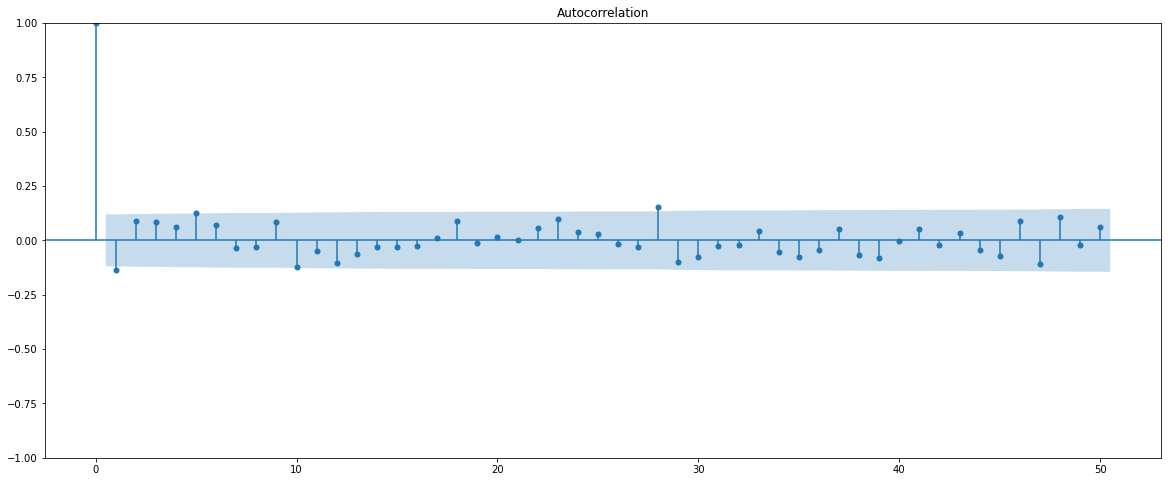

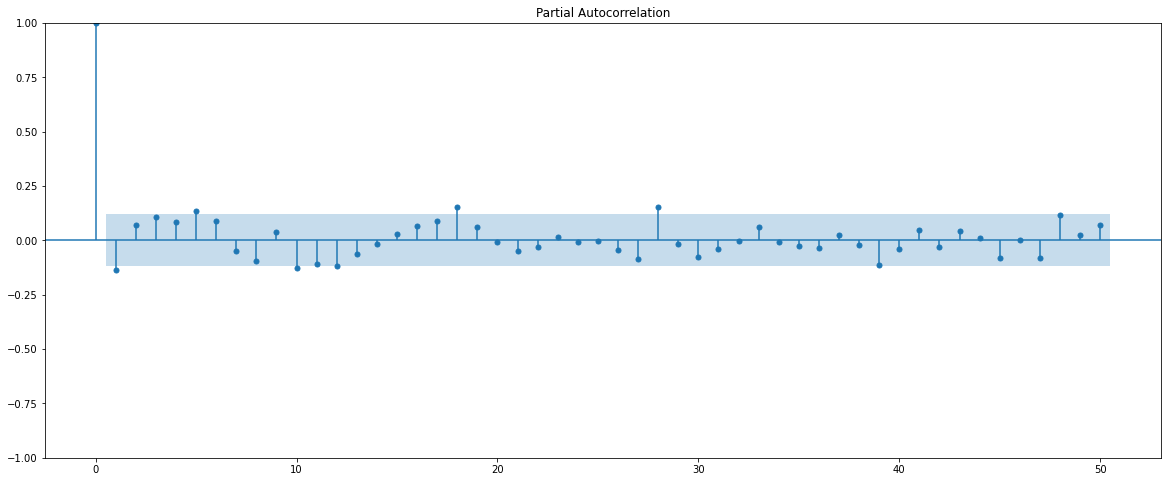

In [56]:
ax = plt.subplot()
ax.figure.set_size_inches((20, 8))
sm.graphics.tsa.plot_acf(data.WAG_C_M_BOX_DIFF[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

ax = plt.subplot()
ax.figure.set_size_inches((20, 8))
sm.graphics.tsa.plot_pacf(data.WAG_C_M_BOX_DIFF[13:].values.squeeze(), lags=50, ax=ax, method='ywm')
plt.show()

Начальные приближения: Q=0, q=5, P=0, p=10

In [66]:
ps = list(range(0, 10))
d = 1
P = 0
qs = list(range(0, 3))
D = 1
Q = 0

In [62]:
parameters = list(itertools.product(ps, qs))
len(parameters)

30

In [75]:
%%time
results = []
best_aic = np.inf
warnings.filterwarnings('ignore')

for p, q in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_BOX, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', p, q)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = (p, q)
    results.append([p, q, model.aic])

warnings.filterwarnings('default')

CPU times: user 17.6 s, sys: 91.9 ms, total: 17.7 s
Wall time: 7.46 s


In [76]:
result_table = pd.DataFrame(results)
result_table.columns = ['p', 'q', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

    p  q        aic
8   2  2 -21.488595
11  3  2 -20.219808
14  4  2 -18.875326
5   1  2  -4.525210
22  7  1  -3.349420


Лучшая модель:

In [77]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_BOX   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Mon, 15 Nov 2021   AIC                            -21.489
Time:                                     21:04:14   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.953      0.000       1.400       1.571
ar.L2         -0.6838      

Её остатки:

Критерий Стьюдента: p=0.254534
Критерий Дики-Фуллера: p=0.000000


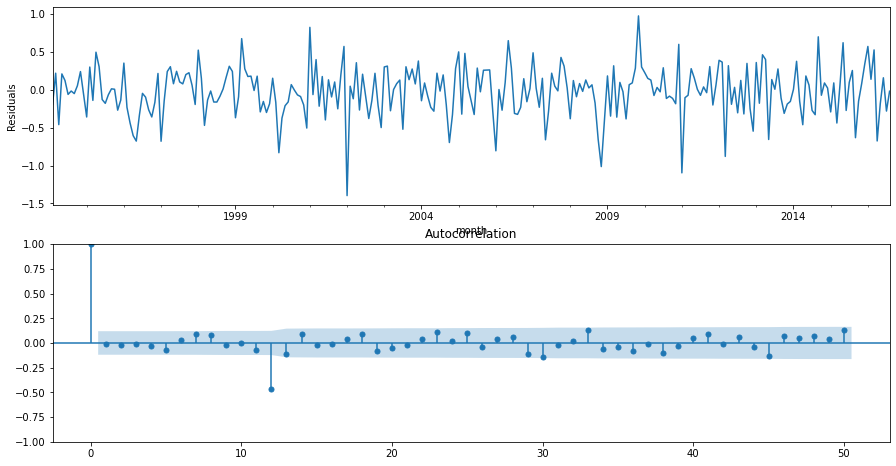

In [70]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

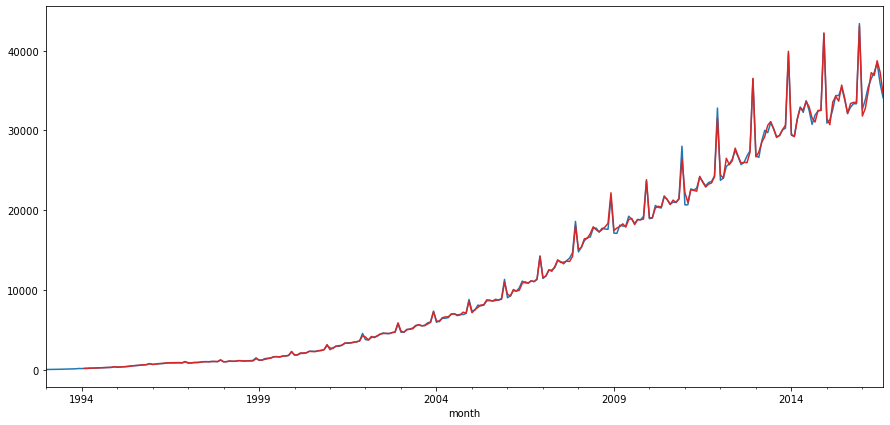

In [79]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15, 7))
data.WAG_C_M.plot()
data.model[13:].plot(color='tab:red')
plt.show()

# Прогноз

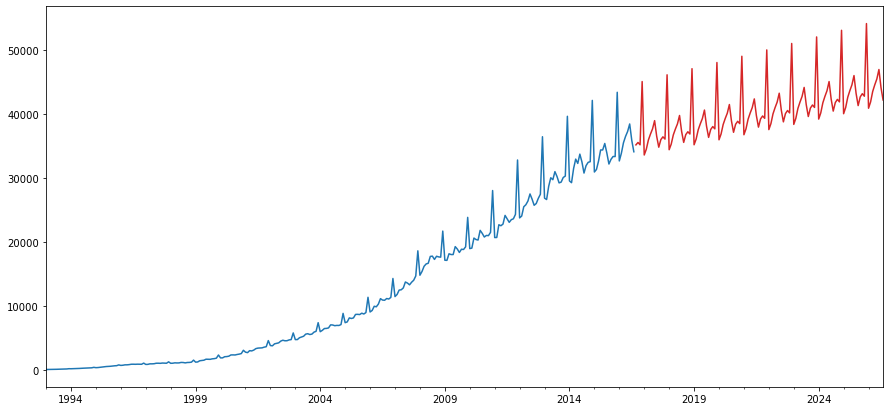

In [97]:
forecast_len = 120

data2 = data[['WAG_C_M']]
date_list = [data2.index[-1] + relativedelta(months=x) for x in range(1, forecast_len + 1)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])

forecast_start = len(data.index)
forecast_end = forecast_start + forecast_len
data2['forecast'] = invboxcox(best_model.predict(start=forecast_start, end=forecast_end), lmbda)

plt.figure(figsize=(15, 7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='tab:red')
plt.show()